In [1]:
# torch.save(influences_collections, "influences_collections-100.tmp.pt")
import torch
import matplotlib.pyplot as plt
from graph_tool.draw import graph_draw
from experiments.visualization import get_graph
from experiments.visualization_utils import plot_influences_distribution
# mnli2_influences_collections = torch.load("/export/home/Experiments/20200805/mnli2_influences-100.pt")
# hans_influences_collections = torch.load("/export/home/Experiments/20200811/hans_influences_collections.pt")
hans_influences_collections = torch.load("/export/home/Experiments/20200818/hans_influences_collections.pt")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


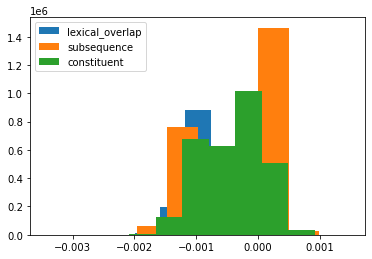

In [3]:
# plot_influences_distribution(mnli2_influences_collections, "MNLI-2")
for label_index, label in enumerate(["lexical_overlap", "subsequence", "constituent"]):
    plot_influences_distribution(hans_influences_collections[label_index], label)
plt.legend()

In [4]:
for _hans_influences_collections in hans_influences_collections:
    for L in _hans_influences_collections:
        for key, val in L.items():
            L[key] = val * 100

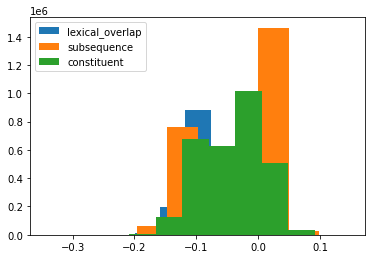

In [6]:
# plot_influences_distribution(mnli2_influences_collections, "MNLI-2")
for label_index, label in enumerate(["lexical_overlap", "subsequence", "constituent"]):
    plot_influences_distribution(hans_influences_collections[label_index], label)
plt.legend()

In [ ]:
g, outputs = get_graph(
    [mnli2_influences_collections] +
    hans_influences_collections)
# g, outputs = get_graph(hans_influences_collections)

In [7]:
from experiments.visualization import *
influences_collections_list = hans_influences_collections
# influences_collections_list = ([mnli2_influences_collections] +
#                                 hans_influences_collections)




influences_collections_list_flatten = []
for influences_collections in influences_collections_list:
    # Assume they all have the same lengths
    if len(influences_collections_list[0][0]) != len(influences_collections[0]):
        raise ValueError
    influences_collections_list_flatten.extend(influences_collections)

# Note they share the same training dataset
possible_datapoints, datapoints_map = get_datapoints_map(
    influences_collections=influences_collections_list_flatten)

g = gt.Graph(directed=True)
# Edge properties
e_colors = g.new_edge_property("int")
e_weights = g.new_edge_property("double")
e_signed_influences = g.new_edge_property("double")
e_unsigned_influences = g.new_edge_property("double")
# Vertex properties
v_sizes = g.new_vertex_property("int")
v_colors = g.new_vertex_property("int")
v_data_indices = g.new_vertex_property("string")
v_positions = g.new_vertex_property("vector<double>")
v_positive_positions = g.new_vertex_property("vector<double>")
v_negative_positions = g.new_vertex_property("vector<double>")

train_vertices = []
eval_vertices_collections = []

NUM_INFLUENCE_COLLECTIONS = len(influences_collections_list)
VERTEX_COLORS = range(2, 2 + NUM_INFLUENCE_COLLECTIONS)
HELPFUL_EDGE_COLOR = 0
HARMFUL_EDGE_COLOR = 1
TRAIN_VERTEX_SIZE = 3
TRAIN_VERTEX_COLOR = 0
EVAL_VERTICES_RADIUS = 3
TRAIN_VERTICES_RADIUS = 2

# Add train vertices
for datapoint_index in trange(len(possible_datapoints)):
    v = g.add_vertex()
    v_sizes[v] = TRAIN_VERTEX_SIZE
    v_colors[v] = TRAIN_VERTEX_COLOR
    v_data_indices[v] = f"train-{datapoint_index}"
    train_vertices.append(v)

# Add eval vertices
for i, influences_collections in enumerate(influences_collections_list):

    eval_vertices = []
    for datapoint_index in trange(len(influences_collections)):
        v = g.add_vertex()
        v_sizes[v] = 10
        v_colors[v] = VERTEX_COLORS[i]
        v_data_indices[v] = f"A_eval-{datapoint_index}"

        base_degree = (360 / NUM_INFLUENCE_COLLECTIONS) * i
        fine_degree = (360 / NUM_INFLUENCE_COLLECTIONS / len(influences_collections)) * datapoint_index
        x_y_coordinate = get_circle_coordinates(
            r=EVAL_VERTICES_RADIUS,
            degree=base_degree + fine_degree)
        position = np.random.normal(x_y_coordinate, 0.1)
        v_positions[v] = position
        v_positive_positions[v] = position
        v_negative_positions[v] = position
        eval_vertices.append(v)

    eval_vertices_collections.append(eval_vertices)

# Add edges
def add_edges(influences_collections: List[Dict[int, float]],
              eval_vertices: List[gt.Vertex]) -> None:
    for eval_index, influences in enumerate(tqdm(influences_collections)):
        for train_index, train_influence in influences.items():
            # Negative influence is helpful (when the prediction is wrong)
            if train_influence < 0.0:
                train_vertex = train_vertices[datapoints_map[train_index]]
                eval_vertex = eval_vertices[eval_index]
                e = g.add_edge(train_vertex, eval_vertex)
                e_colors[e] = HELPFUL_EDGE_COLOR
                e_weights[e] = np.abs(train_influence)
                e_signed_influences[e] = train_influence
                e_unsigned_influences[e] = np.abs(train_influence)
            else:
                train_vertex = train_vertices[datapoints_map[train_index]]
                eval_vertex = eval_vertices[eval_index]
                e = g.add_edge(train_vertex, eval_vertex)
                e_colors[e] = HARMFUL_EDGE_COLOR
                e_weights[e] = np.abs(train_influence)
                e_signed_influences[e] = train_influence
                e_unsigned_influences[e] = np.abs(train_influence)

for i, influences_collections in enumerate(influences_collections_list):
    add_edges(influences_collections, eval_vertices_collections[i])


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


In [8]:
outputs = []
for train_vertex in tqdm(train_vertices):
    _positive_points = []
    _negative_points = []
    _positive_influences = []
    _negative_influences = []
    for e in train_vertex.all_edges():
        target = e.target()
        if e_signed_influences[e] > 0:
            _positive_points.append(v_positions[target])
            _positive_influences.append(e_unsigned_influences[e])
        else:
            _negative_points.append(v_positions[target])
            _negative_influences.append(e_unsigned_influences[e])
    
    outputs.append((len(_positive_points), len(_negative_points)))

100%|██████████| 30000/30000 [01:37<00:00, 307.67it/s]


In [9]:
outputs = np.array(outputs)

In [10]:
np.mean(outputs[:, 0]), np.mean(outputs[:, 1]), ((outputs > 0).sum(axis=1) == 2).mean()

(150.0, 150.0, 0.0)

In [28]:
np.mean(outputs[:, 0]), np.mean(outputs[:, 1]), ((outputs > 0).sum(axis=1) == 2).mean()

(2.951609738696156, 0.6156782306251672, 0.05049496120574334)

In [8]:
def get_edge_masks(g, keep_positive: bool):
    edge_pen_widths = g.new_edge_property("double")
    edge_weights = g.edge_properties["weights"]
    edge_signed_influences = g.edge_properties["signed_influences"]
    for e in g.edges():
        if keep_positive:
            if edge_signed_influences[e] >= 0.0:
                edge_pen_widths[e] = edge_weights[e]
            else:
                edge_pen_widths[e] = 0.0
        else:
            if edge_signed_influences[e] < 0.0:
                edge_pen_widths[e] = edge_weights[e]
            else:
                edge_pen_widths[e] = 0.0
    return edge_pen_widths

In [9]:
import matplotlib.cm as plt_cm

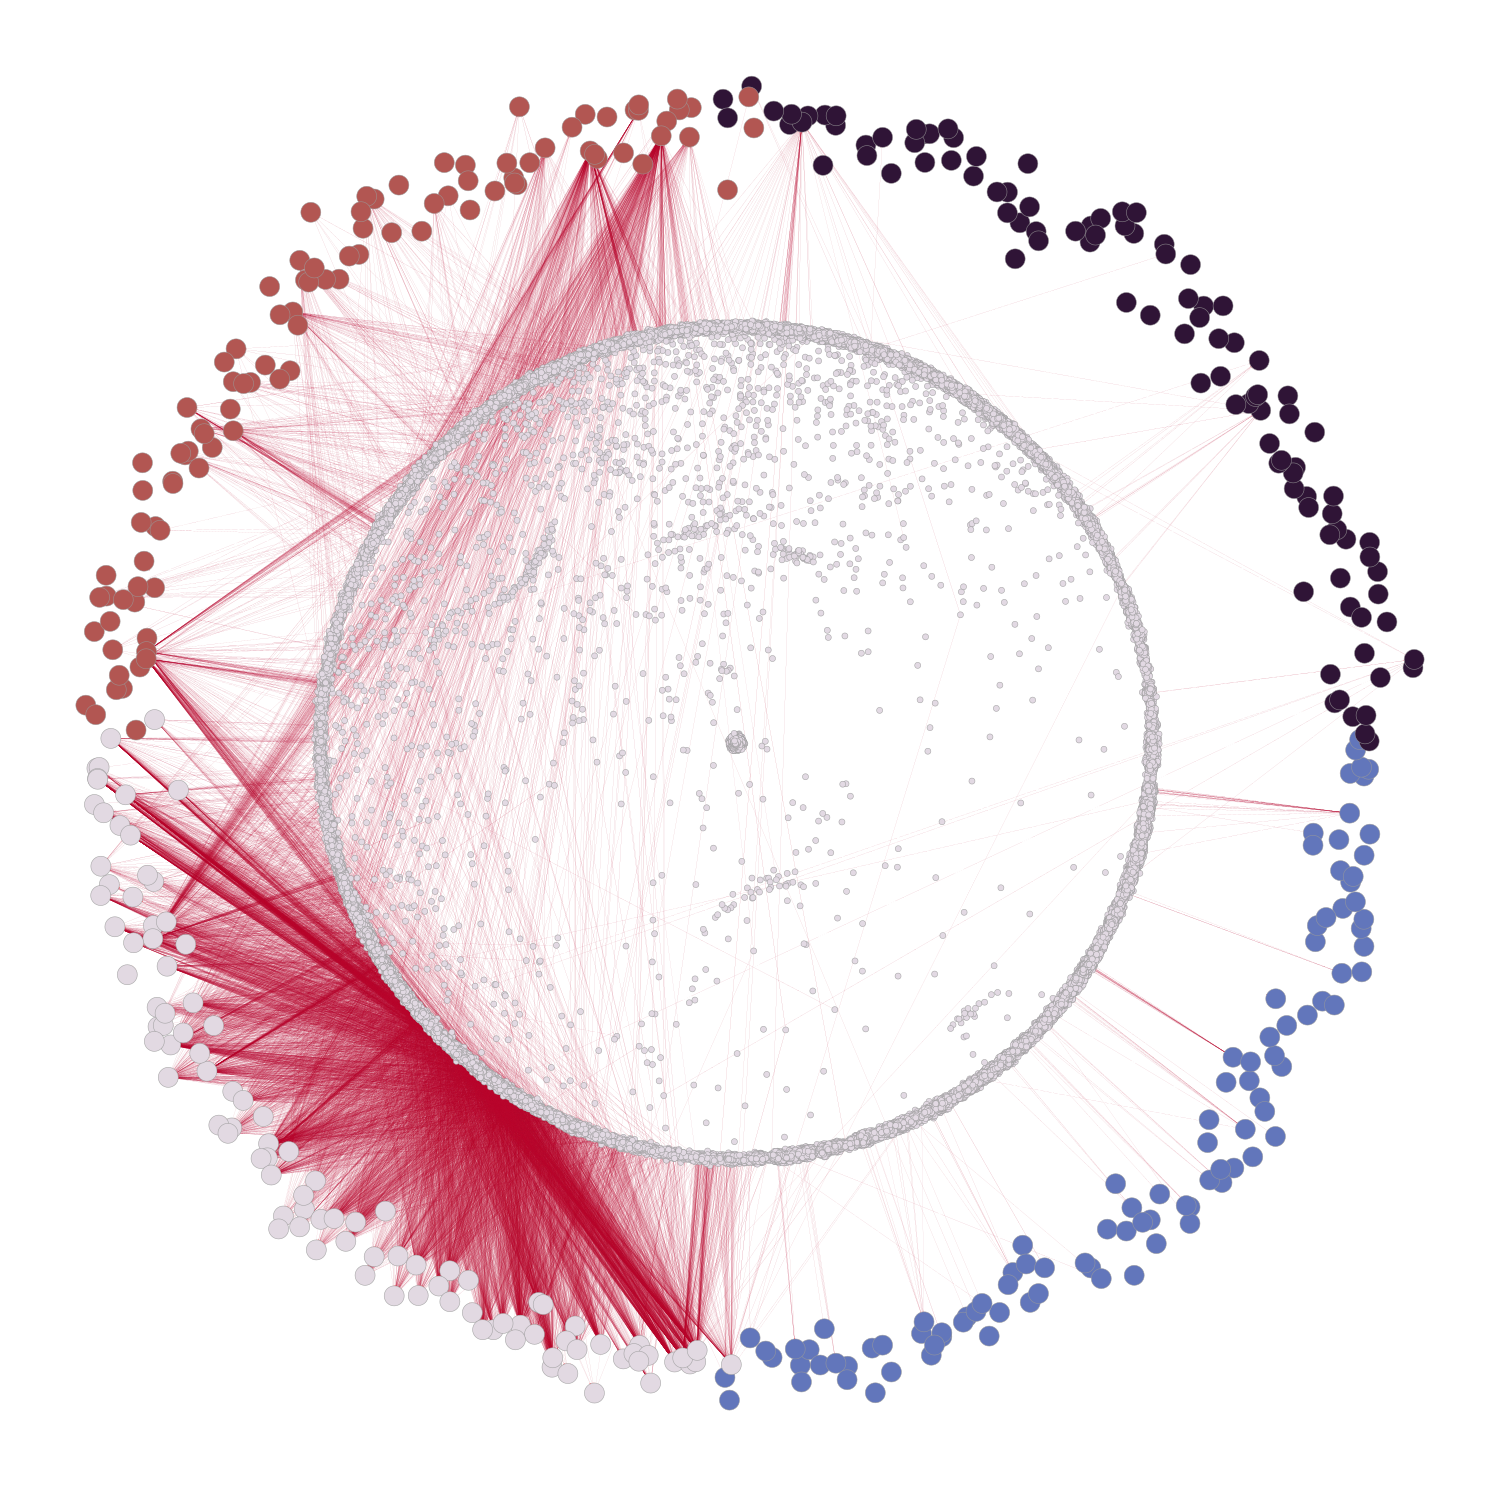

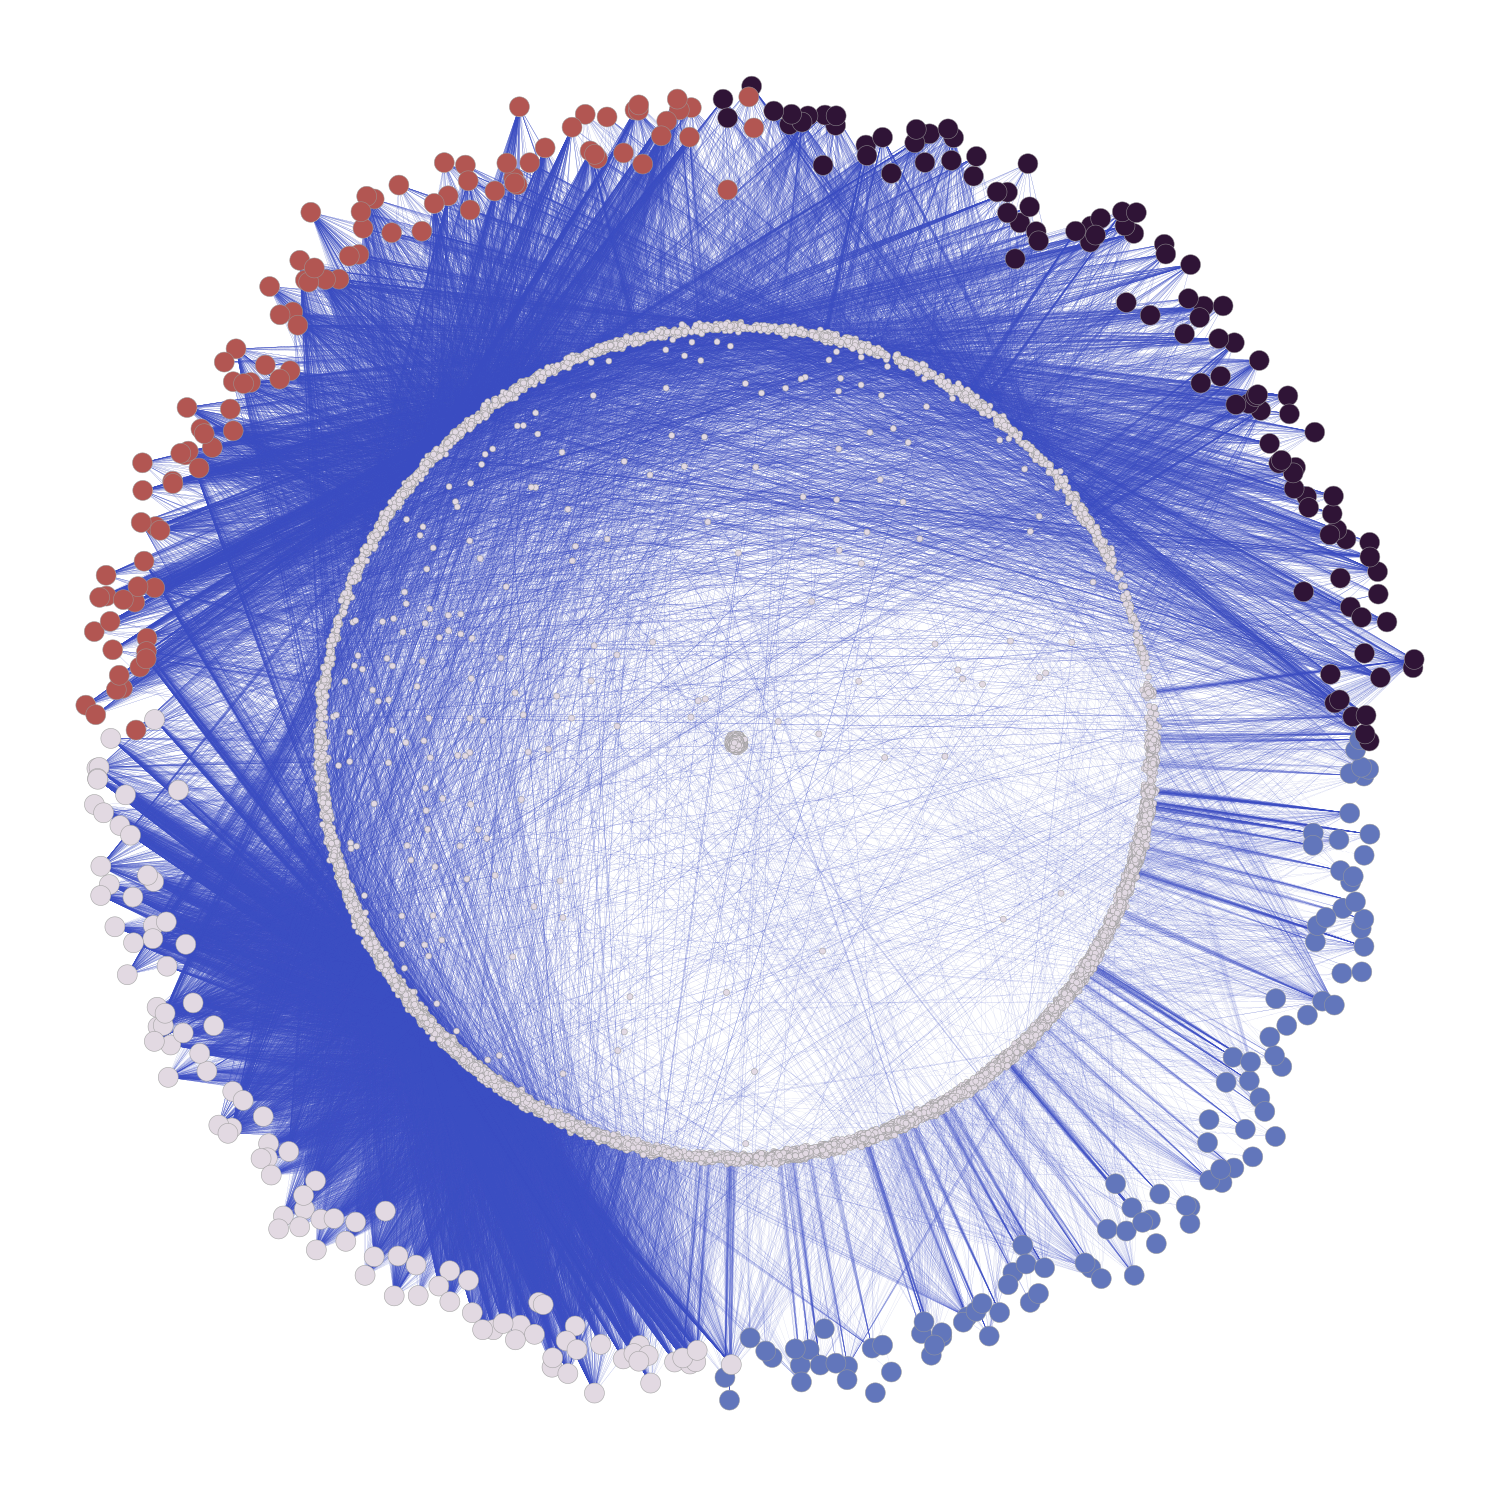

In [15]:
def plot(g):
    outputs_positive = graph_draw(g,
               pos=g.vertex_properties["positive_positions"],
               edge_color=g.edge_properties["colors"],
               vertex_size=g.vertex_properties["sizes"],
               vertex_fill_color=g.vertex_properties["colors"],
               vcmap=plt_cm.twilight,
               ecmap=plt_cm.coolwarm,
               output_size=(750, 750),
               edge_pen_width=get_edge_masks(g, keep_positive=True),
               # vertex_text=g.vertex_properties["data_indices"],
               # vertex_font_size=5,
               # output="20200815-0.png"
              )

    outputs_negative = graph_draw(g,
               pos=g.vertex_properties["negative_positions"],
               edge_color=g.edge_properties["colors"],
               vertex_size=g.vertex_properties["sizes"],
               vertex_fill_color=g.vertex_properties["colors"],
               vcmap=plt_cm.twilight,
               ecmap=plt_cm.coolwarm,
               output_size=(750, 750),
               edge_pen_width=get_edge_masks(g, keep_positive=False),
               # vertex_text=g.vertex_properties["data_indices"],
               # vertex_font_size=5,
               # output="20200815-1.png"

    )
    
    return outputs_positive, outputs_negative
outputs_positive, outputs_negative = plot(g)

In [27]:
for v in g.vertices():
    color = g.vertex_properties["colors"][v]
    if color == 6:
        print(g.vertex_properties["positions"][v])

array([0.06625456, 2.86033917])

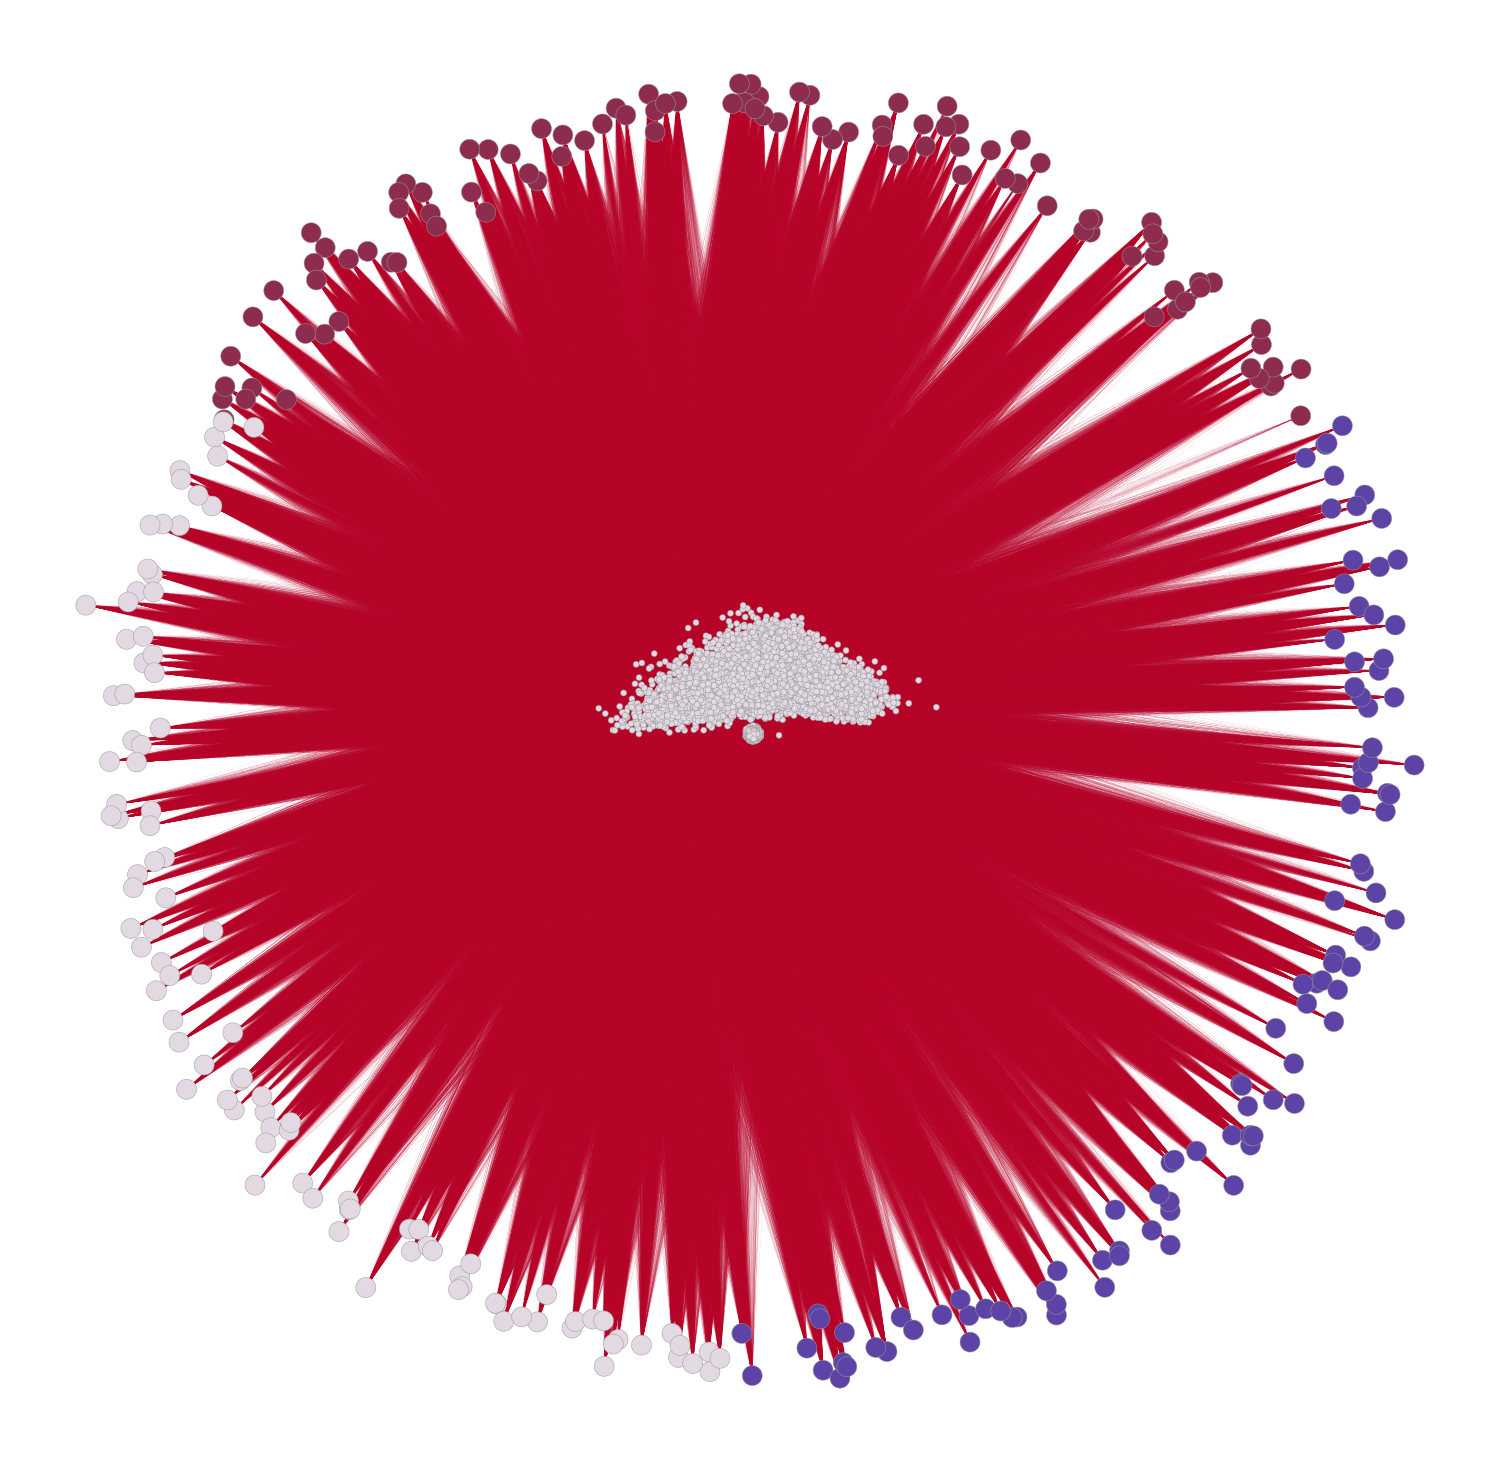

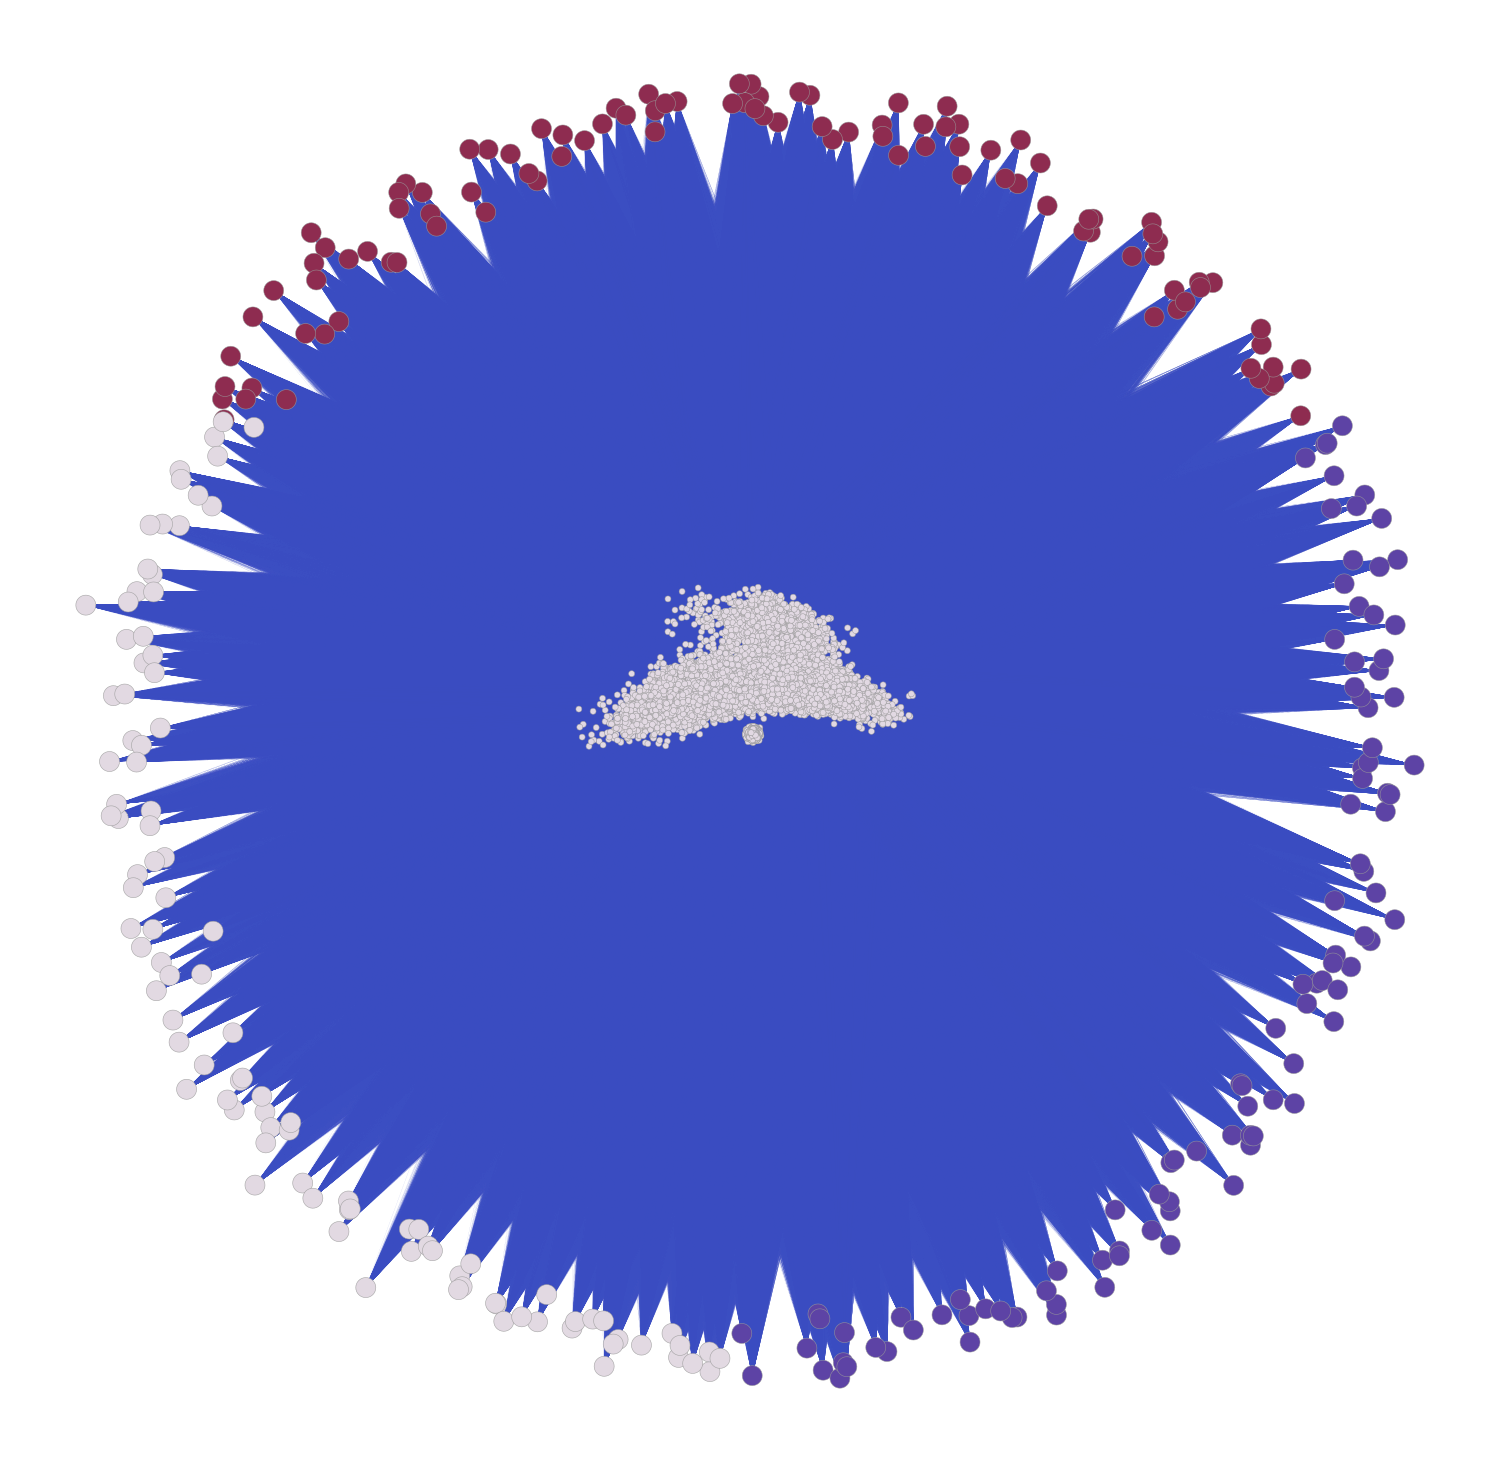

In [10]:
def plot(g):
    graph_draw(g,
               pos=g.vertex_properties["positive_positions"],
               edge_color=g.edge_properties["colors"],
               vertex_size=g.vertex_properties["sizes"],
               vertex_fill_color=g.vertex_properties["colors"],
               vcmap=plt_cm.twilight,
               ecmap=plt_cm.coolwarm,
               output_size=(750, 750),
               edge_pen_width=get_edge_masks(g, keep_positive=True),
               # vertex_text=g.vertex_properties["data_indices"],
               # vertex_font_size=5,
               # output="20200815-0.png"
              )

    graph_draw(g,
               pos=g.vertex_properties["negative_positions"],
               edge_color=g.edge_properties["colors"],
               vertex_size=g.vertex_properties["sizes"],
               vertex_fill_color=g.vertex_properties["colors"],
               vcmap=plt_cm.twilight,
               ecmap=plt_cm.coolwarm,
               output_size=(750, 750),
               edge_pen_width=get_edge_masks(g, keep_positive=False),
               # vertex_text=g.vertex_properties["data_indices"],
               # vertex_font_size=5,
               # output="20200815-1.png"

    )
plot(g)

In [11]:
from experiments.visualization import get_circle_coordinates

In [14]:
EVAL_VERTICES_RADIUS = 2
NUM_INFLUENCE_COLLECTIONS = 3
for i in range(3):
    base_degree = (360 / NUM_INFLUENCE_COLLECTIONS) * i
    fine_degree = (360 / NUM_INFLUENCE_COLLECTIONS / 2) * 0
    x_y_coordinate = get_circle_coordinates(
        r=EVAL_VERTICES_RADIUS,
        degree=base_degree + fine_degree)
    print(x_y_coordinate)

(0.0, 2.0)
(1.7320508075688774, -0.9999999999999996)
(-1.7320508075688767, -1.0000000000000009)


In [20]:
i

201